In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
from PIL import Image
from io import BytesIO
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import tarfile
from tarfile import open

In [2]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

from tqdm import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')
# import os
# os.chdir('path/to/zip/file/')
# !tar -xzvf CINIC-10.tar.gz

Mounted at /content/drive


In [4]:

tar = open("/content/drive/MyDrive/Fall24/CINIC-10.tar.gz", "r:gz")
tar.extractall()
  # tar
# tar.close()

<font size=5> Dataset

In [5]:
class CINIC10Dataset:
  def __init__(self, batch_size=64, root='.'):
    # self.transform = transforms.Compose([
    #         transforms.Resize((32, 32)),  # Adjust size as needed
    #         transforms.ToTensor(),
    #         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Adjust normalization values
    #     ])
    initial_transform = transforms.Compose([
          transforms.Resize((32, 32)),
          transforms.ToTensor()
      ])
    self.batch_size = batch_size

    temp_dataset = datasets.ImageFolder(root=f"{root}/train", transform=initial_transform)
    temp_loader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False)

    # Calculate mean and std
    mean, std = self.calculate_mean_std(temp_loader)

     # Define transformations with calculated mean and std
    self.transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # initialize dataset and data loaders
    self.train_dataset = datasets.ImageFolder(root=f"./train", transform=self.transform)
    self.train_dataloader = DataLoader(self.train_dataset , batch_size=batch_size , \
                                       shuffle=True, num_workers=2)

    self.valid_dataset = datasets.ImageFolder(root=f"./valid", transform=self.transform)
    self.valid_dataloader = DataLoader(self.valid_dataset , batch_size=batch_size , \
                                       shuffle=True, num_workers=2)

    self.test_dataset = datasets.ImageFolder(root=f"./test", transform=self.transform)
    self.test_dataloader = DataLoader(self.test_dataset , batch_size=batch_size , \
                                      shuffle=True, num_workers=2)

  #  You should normalize the images to zero mean and unit variance for pre-processing.
  # First normalize your image pixel values to (0,1) range, calculate the dataset mean/std values,
  # and then normalize the images to be zero mean and unit variance.
  def calculate_mean_std(self, loader):
        # Calculate mean and std across all batches in the loader
        mean = 0.0
        std = 0.0
        total_images_count = 0
        for images, _ in loader:
            batch_samples = images.size(0)  # batch size (the last batch can have smaller size)
            images = images.view(batch_samples, images.size(1), -1)  # flatten each channel
            mean += images.mean(2).sum(0)
            std += images.std(2).sum(0)
            total_images_count += batch_samples

        mean /= total_images_count
        std /= total_images_count
        return mean, std



In [ ]:
# load data in memory using tar
# tar = open("/content/drive/MyDrive/Fall2024/CINIC-10.tar.gz", "r:gz")
# tar.extractall()


In [ ]:
# tar_path = "/content/drive/MyDrive/Fall2024/CINIC-10.tar.gz"
# cinic10_dataloader = CINIC10DataLoader(tar_path, batch_size=64)

In [ ]:
# mean, std = calculate_mean_std(tar_path)
# cinic10_loader = CINIC10DataLoader(tar_path=tar_path, batch_size=64, mean=mean, std=std)

<font size=5>TRAINING

In [ ]:
# Train the networks using the given training data for 20 epochs. For the main experiment setting,
# we suggest starting with a mini-batch size of 128, ADAM optimizer with learning rate α = 0.001,
# β1 = 0.9 and β2 = 0.999. You are free to experiment with other learning rates and other optimizers.
# Please use cross entropy loss for your main experiment. Record the error after each step (i.e. after each batch)
# so you can monitor it and plot it to show results. During training, you should test on the validation set
# at some regular intervals; say every 5 epochs, to check whether the model is overfitting.
# Note: To plot the loss function or accuracy, you can use pylab, matplotlib or tensorboard to show the curve.

In [6]:
epochs = 20
mini_batch_size = 128
learning_rate = 0.001
beta1 = 0.9
beta2 = 0.999

In [7]:
dataloader = CINIC10Dataset(batch_size=mini_batch_size)


<font size=6>ResNet-9 network

In [8]:
# Lists to store losses for plotting later
train_losses_rn9 = []
train_accuracies_rn9 = []
# val_accuracies = []
# val_losses = []

batch_losses_rn9 = []
validation_losses_rn9 = []
validation_accuracies_rn9 = []

In [9]:
# Define a basic residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        # Define two convolutional layers with BatchNorm and ReLU activations
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Define a shortcut to match input/output dimensions if necessary
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        # Pass the input through the convolution layers and the shortcut
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # Add the input (residual connection)
        out = F.relu(out)  # Final ReLU activation
        return out


# Define the ResNet-9 model
class ResNet9(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet9, self).__init__()

        # Initial convolution layer
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)  # 3 input channels (RGB), 16 output channels
        self.bn1 = nn.BatchNorm2d(16)

        # Define residual blocks
        self.block1 = ResidualBlock(16, 16, stride=1)
        self.block2 = ResidualBlock(16, 32, stride=2)
        self.block3 = ResidualBlock(32, 64, stride=2)
        self.block4 = ResidualBlock(64, 64, stride=1)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 256)  # Assuming 32x32 input images
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Initial convolution and batch norm
        x = F.relu(self.bn1(self.conv1(x)))

        # Pass through the residual blocks
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        # Flatten the output of the last block and pass through fully connected layers
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Output layer

        return x

In [15]:
model_rn9 = ResNet9(num_classes=10)

# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_rn9.to(device)

# with l2-regularization
optimizer = optim.Adam(model_rn9.parameters(), lr=learning_rate, weight_decay=0.0001, betas=(beta1, beta2))
# without l2-reg
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(beta1, beta2))

criterion = nn.CrossEntropyLoss()

In [11]:
# IGSM attack function
def igsm_attack(model, images, labels, epsilon=0.12, alpha=0.006, iterations=20):
    images = images.clone().detach().requires_grad_(True)
    adv_images = images.clone().detach()

    for _ in range(iterations):
        adv_images.requires_grad = True

        outputs = model(adv_images)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()

        grad_sign = adv_images.grad.sign()
        adv_images = adv_images + alpha * grad_sign
        perturbation = torch.clamp(adv_images - images, -epsilon, epsilon)
        adv_images = torch.clamp(images + perturbation, 0, 1).detach().requires_grad_(True)

    return adv_images

In [16]:
for epoch in tqdm(range(epochs)):
    model_rn9.train( )  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    print(f"Starting epoch {epoch + 1}/{epochs}")
    for i, data in enumerate(dataloader.train_dataloader,0):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()  # Zero the gradients
      outputs = model_rn9(inputs)  # Forward pass

      loss = criterion(outputs, labels)  # Calculate loss
      loss.backward()  # Backward pass
      optimizer.step()  # Update weights

      # Accumulate loss and accuracy metrics
      running_loss += loss.item() * inputs.size(0)
      batch_losses_rn9.append(loss.item())  # Track batch loss

      # Calculate batch accuracy
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      # # Print batch progress every 100 batches
      # if (i + 1) % 100 == 0:
      #     print(f"Epoch [{epoch + 1}], Batch [{i + 1}], Batch Loss: {loss.item():.4f}")

      # add validation step every 100
      # model.eval

    # Epoch lossand accuracy
    epoch_loss = running_loss / total
    epoch_accuracy = correct / total

    train_losses_rn9.append(epoch_loss)
    train_accuracies_rn9.append(epoch_accuracy)
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

    # Validation Step every 5 epochs
    if (epoch + 1) % 5 == 0:
        model_rn9.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():  # Disable gradient calculation for validation
            for val_inputs, val_labels in dataloader.valid_dataloader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model_rn9(val_inputs)
                val_batch_loss = criterion(val_outputs, val_labels)
                val_loss += val_batch_loss.item() * val_inputs.size(0)

                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        # Calculate validation metrics
        val_loss /= val_total
        val_accuracy = val_correct / val_total
        validation_losses_rn9.append(val_loss)
        validation_accuracies_rn9.append(val_accuracy)

        print(f'\tValidation after Epoch [{epoch + 1}]: Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}')

    model_rn9.train()  # Set back to training mode after validation
print("Finished training")


  0%|          | 0/20 [00:00<?, ?it/s]

Starting epoch 1/20


  5%|▌         | 1/20 [00:44<14:12, 44.86s/it]

Epoch [1/20], Loss: 1.4902, Accuracy: 0.4493
Starting epoch 2/20


 10%|█         | 2/20 [01:31<13:41, 45.63s/it]

Epoch [2/20], Loss: 1.1349, Accuracy: 0.5875
Starting epoch 3/20


 15%|█▌        | 3/20 [02:13<12:30, 44.15s/it]

Epoch [3/20], Loss: 0.9975, Accuracy: 0.6388
Starting epoch 4/20


 20%|██        | 4/20 [02:57<11:48, 44.27s/it]

Epoch [4/20], Loss: 0.8982, Accuracy: 0.6766
Starting epoch 5/20
Epoch [5/20], Loss: 0.8180, Accuracy: 0.7051


 25%|██▌       | 5/20 [04:21<14:35, 58.34s/it]

	Validation after Epoch [5]: Loss: 0.9896, Accuracy: 0.6485
Starting epoch 6/20


 30%|███       | 6/20 [05:11<12:59, 55.70s/it]

Epoch [6/20], Loss: 0.7421, Accuracy: 0.7339
Starting epoch 7/20


 35%|███▌      | 7/20 [06:00<11:36, 53.57s/it]

Epoch [7/20], Loss: 0.6751, Accuracy: 0.7574
Starting epoch 8/20


 40%|████      | 8/20 [06:47<10:14, 51.24s/it]

Epoch [8/20], Loss: 0.6035, Accuracy: 0.7833
Starting epoch 9/20


 45%|████▌     | 9/20 [07:33<09:07, 49.77s/it]

Epoch [9/20], Loss: 0.5368, Accuracy: 0.8063
Starting epoch 10/20
Epoch [10/20], Loss: 0.4770, Accuracy: 0.8284


 50%|█████     | 10/20 [08:56<09:58, 59.87s/it]

	Validation after Epoch [10]: Loss: 1.0793, Accuracy: 0.6564
Starting epoch 11/20


 55%|█████▌    | 11/20 [09:37<08:08, 54.25s/it]

Epoch [11/20], Loss: 0.4123, Accuracy: 0.8507
Starting epoch 12/20


 60%|██████    | 12/20 [10:23<06:52, 51.53s/it]

Epoch [12/20], Loss: 0.3646, Accuracy: 0.8683
Starting epoch 13/20


 65%|██████▌   | 13/20 [11:07<05:44, 49.27s/it]

Epoch [13/20], Loss: 0.3194, Accuracy: 0.8847
Starting epoch 14/20


 70%|███████   | 14/20 [11:50<04:44, 47.44s/it]

Epoch [14/20], Loss: 0.2779, Accuracy: 0.8993
Starting epoch 15/20
Epoch [15/20], Loss: 0.2478, Accuracy: 0.9110


 75%|███████▌  | 15/20 [13:13<04:51, 58.27s/it]

	Validation after Epoch [15]: Loss: 1.5107, Accuracy: 0.6420
Starting epoch 16/20


 80%|████████  | 16/20 [13:54<03:32, 53.11s/it]

Epoch [16/20], Loss: 0.2247, Accuracy: 0.9181
Starting epoch 17/20


 85%|████████▌ | 17/20 [14:38<02:30, 50.22s/it]

Epoch [17/20], Loss: 0.2027, Accuracy: 0.9274
Starting epoch 18/20


 90%|█████████ | 18/20 [15:20<01:35, 47.77s/it]

Epoch [18/20], Loss: 0.1915, Accuracy: 0.9307
Starting epoch 19/20


 95%|█████████▌| 19/20 [16:01<00:45, 45.85s/it]

Epoch [19/20], Loss: 0.1693, Accuracy: 0.9398
Starting epoch 20/20
Epoch [20/20], Loss: 0.1654, Accuracy: 0.9414


100%|██████████| 20/20 [17:22<00:00, 52.11s/it]

	Validation after Epoch [20]: Loss: 1.8121, Accuracy: 0.6376
Finished training


In [17]:
torch.save(model_rn9.state_dict(), 'model_rn9.pth')

In [18]:
# Set the model to evaluation mode
model_rn9.eval()

test_correct = 0
test_total = 0
# Lists to hold true labels and predictions
all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient calculations for testing
    for inputs, labels in dataloader.test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_rn9(inputs)
        _, predicted = torch.max(outputs, 1)

        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

        # Store predictions and labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f}% ({test_correct/test_total})")

Test Accuracy: 0.6339% (0.6339)


In [19]:
def evaluate_model(model, test_loader, attack=False, epsilon=0.12, alpha=0.006, iterations=20):
    model.eval()
    correct = 0
    total = 0

    for images, labels in tqdm(test_loader, desc="Testing", leave=False):
        images, labels = images.to(device), labels.to(device)

        # Apply adversarial attack if specified
        if attack:
            images = igsm_attack(model, images, labels, epsilon, alpha, iterations)

        with torch.no_grad():
          outputs = model(images)
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"{'Adversarial' if attack else 'Clean'} Accuracy: {accuracy:.2f}% ({correct}/{total})")
    return accuracy  # Optionally return accuracy for logging or analysis

# Evaluate on clean test data
clean_accuracy = evaluate_model(model_rn9, dataloader.test_dataloader)

# Evaluate on adversarial test data with default attack parameters
adv_accuracy1 = evaluate_model(model_rn9, dataloader.test_dataloader, attack=True, epsilon=0.12, alpha=0.006, iterations=20)
adv_accuracy2 = evaluate_model(model_rn9, dataloader.test_dataloader, attack=True, epsilon=0.20, alpha=0.01, iterations=25)

# weak attack
evaluate_model(model_rn9, dataloader.test_dataloader, attack=True, epsilon=0.03, alpha=0.001, iterations=10)

Clean Accuracy: 63.39% (57051/90000)


Adversarial Accuracy: 0.46% (415/90000)


Adversarial Accuracy: 0.15% (133/90000)


Adversarial Accuracy: 16.08% (14471/90000)


16.07888888888889

In [24]:
# Second step
# Second, starting from your pre-trained weights, fine-tune your model through
# the adversarial training pipeline and report accuracy again on benign images
# and IGSM attacked images. Note that you need to generate attacks on the
# adversarially trained model again instead of reusing the originally computed
# attack images. For adversarial training, take IGSM as your attack function and
# test your model with its attacks.

model_adv = ResNet9(num_classes=10)
model_adv.load_state_dict(torch.load("model_rn9.pth"))
model_adv.to(device)

# Set up optimizer
optimizer = optim.Adam(model_adv.parameters(), lr=0.001, weight_decay=0.0001)

<ipython-input-24-e68b58ce547a>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_adv.load_state_dict(torch.load("model_rn9.pth"))


In [25]:

def adversarial_training(
    model,
    train_loader,
    optimizer,
    epsilon=0.12,
    alpha=0.006,
    iterations=20,
    replacement_ratio=0.75,
    epochs=10
):
    model.train()
    criterion = nn.CrossEntropyLoss()

    for epoch in tqdm(range(epochs)):
        epoch_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            batch_size = images.size(0)

            # Generate adversarial examples
            adv_indices = torch.randperm(batch_size)[:int(replacement_ratio * batch_size)]
            adv_images = images.clone()
            adv_images[adv_indices] = igsm_attack(model, images[adv_indices], labels[adv_indices], epsilon, alpha, iterations)

            # Combine clean and adversarial images
            combined_images = adv_images
            combined_labels = labels

            # Forward pass
            outputs = model(combined_images)
            loss = criterion(outputs, combined_labels)
            epoch_loss += loss.item()

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track accuracy
            _, predicted = torch.max(outputs, 1)
            total += combined_labels.size(0)
            correct += (predicted == combined_labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

    print("Adversarial training complete!")

In [26]:
# Run adversarial training
adversarial_training(
    model_adv,
    dataloader.train_dataloader,
    optimizer,
    epsilon=0.12,
    alpha=0.006,
    iterations=20,
    replacement_ratio=0.75,
    epochs=10
)

# Save the fine-tuned model
torch.save(model_adv.state_dict(), "adversarially_trained_resnet9.pth")

 10%|█         | 1/10 [02:50<25:31, 170.11s/it]

Epoch [1/10], Loss: 1266.4708, Accuracy: 36.73%


 20%|██        | 2/10 [05:37<22:27, 168.43s/it]

Epoch [2/10], Loss: 1042.0089, Accuracy: 45.55%


 30%|███       | 3/10 [08:26<19:41, 168.81s/it]

Epoch [3/10], Loss: 981.7257, Accuracy: 48.93%


 40%|████      | 4/10 [11:17<16:58, 169.77s/it]

Epoch [4/10], Loss: 936.9172, Accuracy: 51.37%


 50%|█████     | 5/10 [14:06<14:07, 169.52s/it]

Epoch [5/10], Loss: 905.9245, Accuracy: 52.90%


 60%|██████    | 6/10 [16:54<11:15, 168.78s/it]

Epoch [6/10], Loss: 872.9471, Accuracy: 54.95%


 70%|███████   | 7/10 [19:42<08:25, 168.50s/it]

Epoch [7/10], Loss: 843.6889, Accuracy: 56.55%


 80%|████████  | 8/10 [22:28<05:35, 167.88s/it]

Epoch [8/10], Loss: 816.7679, Accuracy: 58.14%


 90%|█████████ | 9/10 [25:14<02:47, 167.22s/it]

Epoch [9/10], Loss: 786.2623, Accuracy: 59.54%


100%|██████████| 10/10 [28:00<00:00, 168.08s/it]

Epoch [10/10], Loss: 758.7258, Accuracy: 61.03%
Adversarial training complete!


In [28]:
# Evaluate on clean test data
clean_accuracy = evaluate_model(model_adv, dataloader.test_dataloader)

# Evaluate on adversarial test data with default attack parameters
adv_accuracy1 = evaluate_model(model_adv, dataloader.test_dataloader, attack=True, epsilon=0.12, alpha=0.006, iterations=20)
adv_accuracy2 = evaluate_model(model_adv, dataloader.test_dataloader, attack=True, epsilon=0.20, alpha=0.01, iterations=25)

# weak attack
weak_attack = evaluate_model(model_adv, dataloader.test_dataloader, attack=True, epsilon=0.03, alpha=0.001, iterations=10)

Clean Accuracy: 48.65% (43784/90000)


Adversarial Accuracy: 5.77% (5197/90000)


Adversarial Accuracy: 1.80% (1619/90000)


Adversarial Accuracy: 39.45% (35508/90000)


In [29]:
# Qualitative results
# Get a batch of test data
images, labels = next(iter(dataloader.test_dataloader))
images, labels = images.to(device), labels.to(device)

# Select a subset of the batch for visualization
num_samples = 5  # Number of samples to visualize
images = images[:num_samples]
labels = labels[:num_samples]

In [30]:
# apply IGSM attack
model_baseline = ResNet9(num_classes=10)
model_baseline.load_state_dict(torch.load("model_rn9.pth"))
model_baseline.to(device)

model_defended = ResNet9(num_classes=10)
model_defended.load_state_dict(torch.load("adversarially_trained_resnet9.pth"))
model_defended.to(device)

# Generate adversarial examples for the no-defense model
adv_images_no_defense = igsm_attack(
    model=model_baseline,  # Your no-defense model
    images=images,         # Original images
    labels=labels,         # True labels
    epsilon=0.12,          # Perturbation size
    alpha=0.006,           # Step size
    iterations=20          # Number of attack iterations
)

# Generate adversarial examples for the adversarial-trained model
adv_images_adv_trained = igsm_attack(
    model=model_defended,  # Your adversarially-trained model
    images=images,         # Original images
    labels=labels,         # True labels
    epsilon=0.12,          # Perturbation size
    alpha=0.006,           # Step size
    iterations=20          # Number of attack iterations
)

<ipython-input-30-eceb8177ea0d>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_baseline.load_state_dict(torch.load("model_rn9.pth"))
<ipython-input-30-eceb8177ea0d>:

In [31]:
# Move tensors to CPU for visualization
images_cpu = images.cpu()
adv_images_no_defense_cpu = adv_images_no_defense.cpu()
adv_images_adv_trained_cpu = adv_images_adv_trained.cpu()

In [32]:
# No-defense model predictions
outputs = model_baseline(adv_images_no_defense)
_, predicted_no_defense = torch.max(outputs, 1)

# Adversarial-trained model predictions
outputs = model_defended(adv_images_adv_trained)
_, predicted_adv_trained = torch.max(outputs, 1)

print("No-defense model predictions:", predicted_no_defense)
print("Adversarial-trained model predictions:", predicted_adv_trained)

No-defense model predictions: tensor([4, 8, 0, 9, 3], device='cuda:0')
Adversarial-trained model predictions: tensor([4, 0, 8, 3, 4], device='cuda:0')


In [33]:
import matplotlib.pyplot as plt
import numpy as np

In [34]:
def visualize_images(original, adversarial, labels, predictions, title):
    """
    Visualizes original and adversarial images with their labels and predictions.

    Args:
    - original: Tensor of original images.
    - adversarial: Tensor of adversarial images.
    - labels: Ground truth labels (as a list or array).
    - predictions: Model predictions (as a list or array).
    - title: Title for the visualization.
    """
    num_samples = len(original)  # Number of images to visualize
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    fig.suptitle(title, fontsize=16)

    for i in range(num_samples):
        # Original image
        axes[0, i].imshow(np.transpose(original[i].cpu().numpy(), (1, 2, 0)))
        axes[0, i].set_title(f"True: {labels[i]}")
        axes[0, i].axis("off")

        # Adversarial image
        axes[1, i].imshow(np.transpose(adversarial[i].cpu().numpy(), (1, 2, 0)))
        axes[1, i].set_title(f"Pred: {predictions[i]}")
        axes[1, i].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

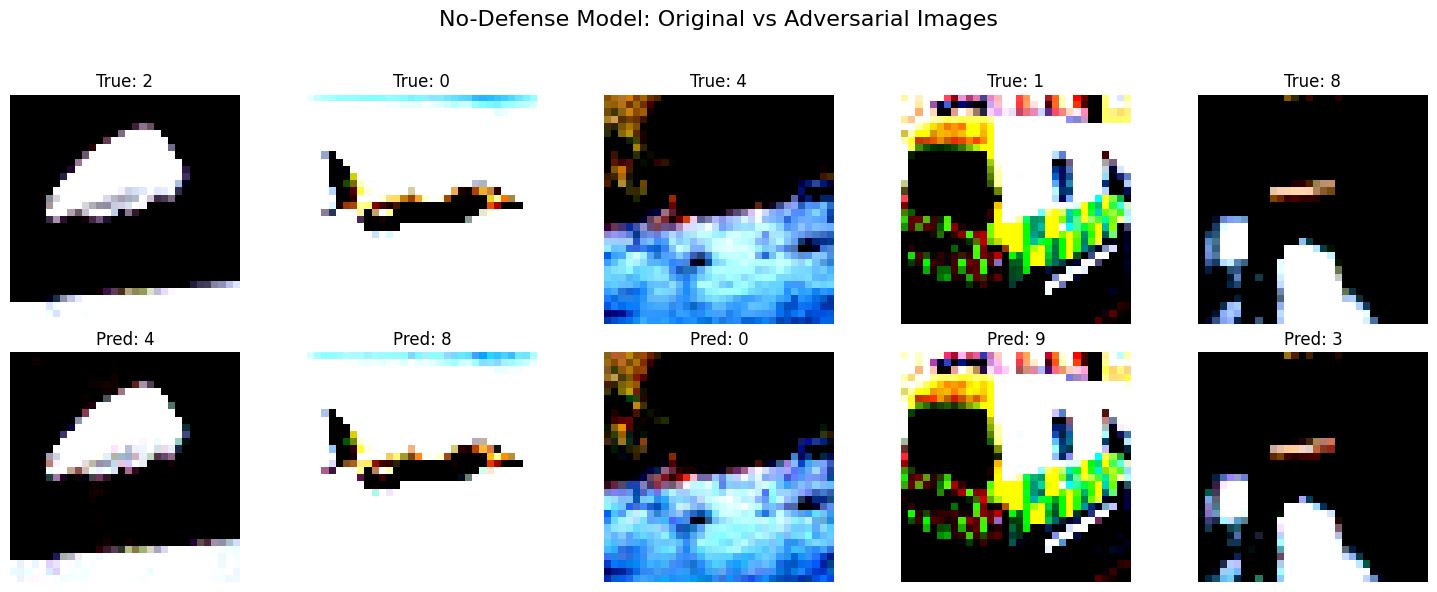

In [36]:
# Generate predictions for adversarial images
outputs = model_baseline(adv_images_no_defense.to(device))
_, predictions_no_defense = torch.max(outputs, 1)

# Visualize original and adversarial images
visualize_images(
    original=images_cpu,
    adversarial=adv_images_no_defense_cpu.detach(),
    labels=labels.cpu().numpy(),
    predictions=predictions_no_defense.cpu().numpy(),
    title="No-Defense Model: Original vs Adversarial Images"
)

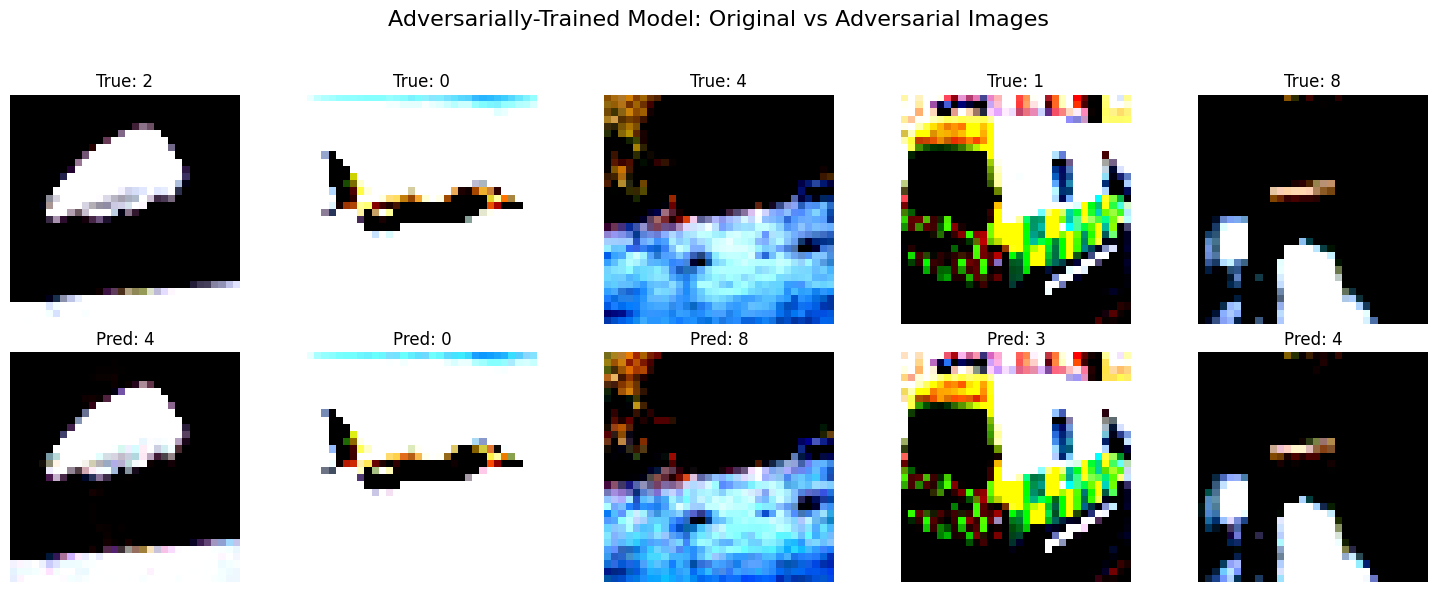

In [38]:
# Generate predictions for adversarial images
outputs = model_defended(adv_images_adv_trained.to(device))
_, predictions_adv_trained = torch.max(outputs, 1)

# Visualize original and adversarial images
visualize_images(
    original=images_cpu,
    adversarial=adv_images_adv_trained_cpu.detach(),
    labels=labels.cpu().numpy(),
    predictions=predictions_adv_trained.cpu().numpy(),
    title="Adversarially-Trained Model: Original vs Adversarial Images"
)

In [39]:
no_defense_accuracy = (predictions_no_defense == labels).sum().item() / len(labels)
adv_trained_accuracy = (predictions_adv_trained == labels).sum().item() / len(labels)
print(f"No-Defense Accuracy: {no_defense_accuracy:.2f}")
print(f"Adversarially-Trained Accuracy: {adv_trained_accuracy:.2f}")

No-Defense Accuracy: 0.00
Adversarially-Trained Accuracy: 0.20
